
  Dashboard Inputs


• Account type filter for Q1 Like savings,current,fixed deposit,salary:  savings
• Loan type for status distribution (e.g., Home/Car/Auto/Education/Personal/Business):  home
• Top-N customers for overall activity (e.g., 10):  5



• High-value transactions grouping:
  H1 = by Transaction Type, H2 = by City, H3 = by Customer, H4 = Type+City (two mini-bars)


  Enter H1/H2/H3/H4:  h3


C:\Users\dines\AppData\Local\Temp\ipykernel_15764\180987853.py:53: DeprecationWarning: Call to deprecated function stored_results. Reason: The property counterpart 'stored_results' will be added in a future release, and this method will be removed.
  for result in cursor.stored_results():
C:\Users\dines\AppData\Local\Temp\ipykernel_15764\180987853.py:53: DeprecationWarning: Call to deprecated function stored_results. Reason: The property counterpart 'stored_results' will be added in a future release, and this method will be removed.
  for result in cursor.stored_results():
C:\Users\dines\AppData\Local\Temp\ipykernel_15764\180987853.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x="city", y="total_customers", ax=ax, palette=PALETTES["p2"])
C:\Users\dines\AppData\Local\Temp\ipykernel_15764\180987853.py:53: DeprecationW

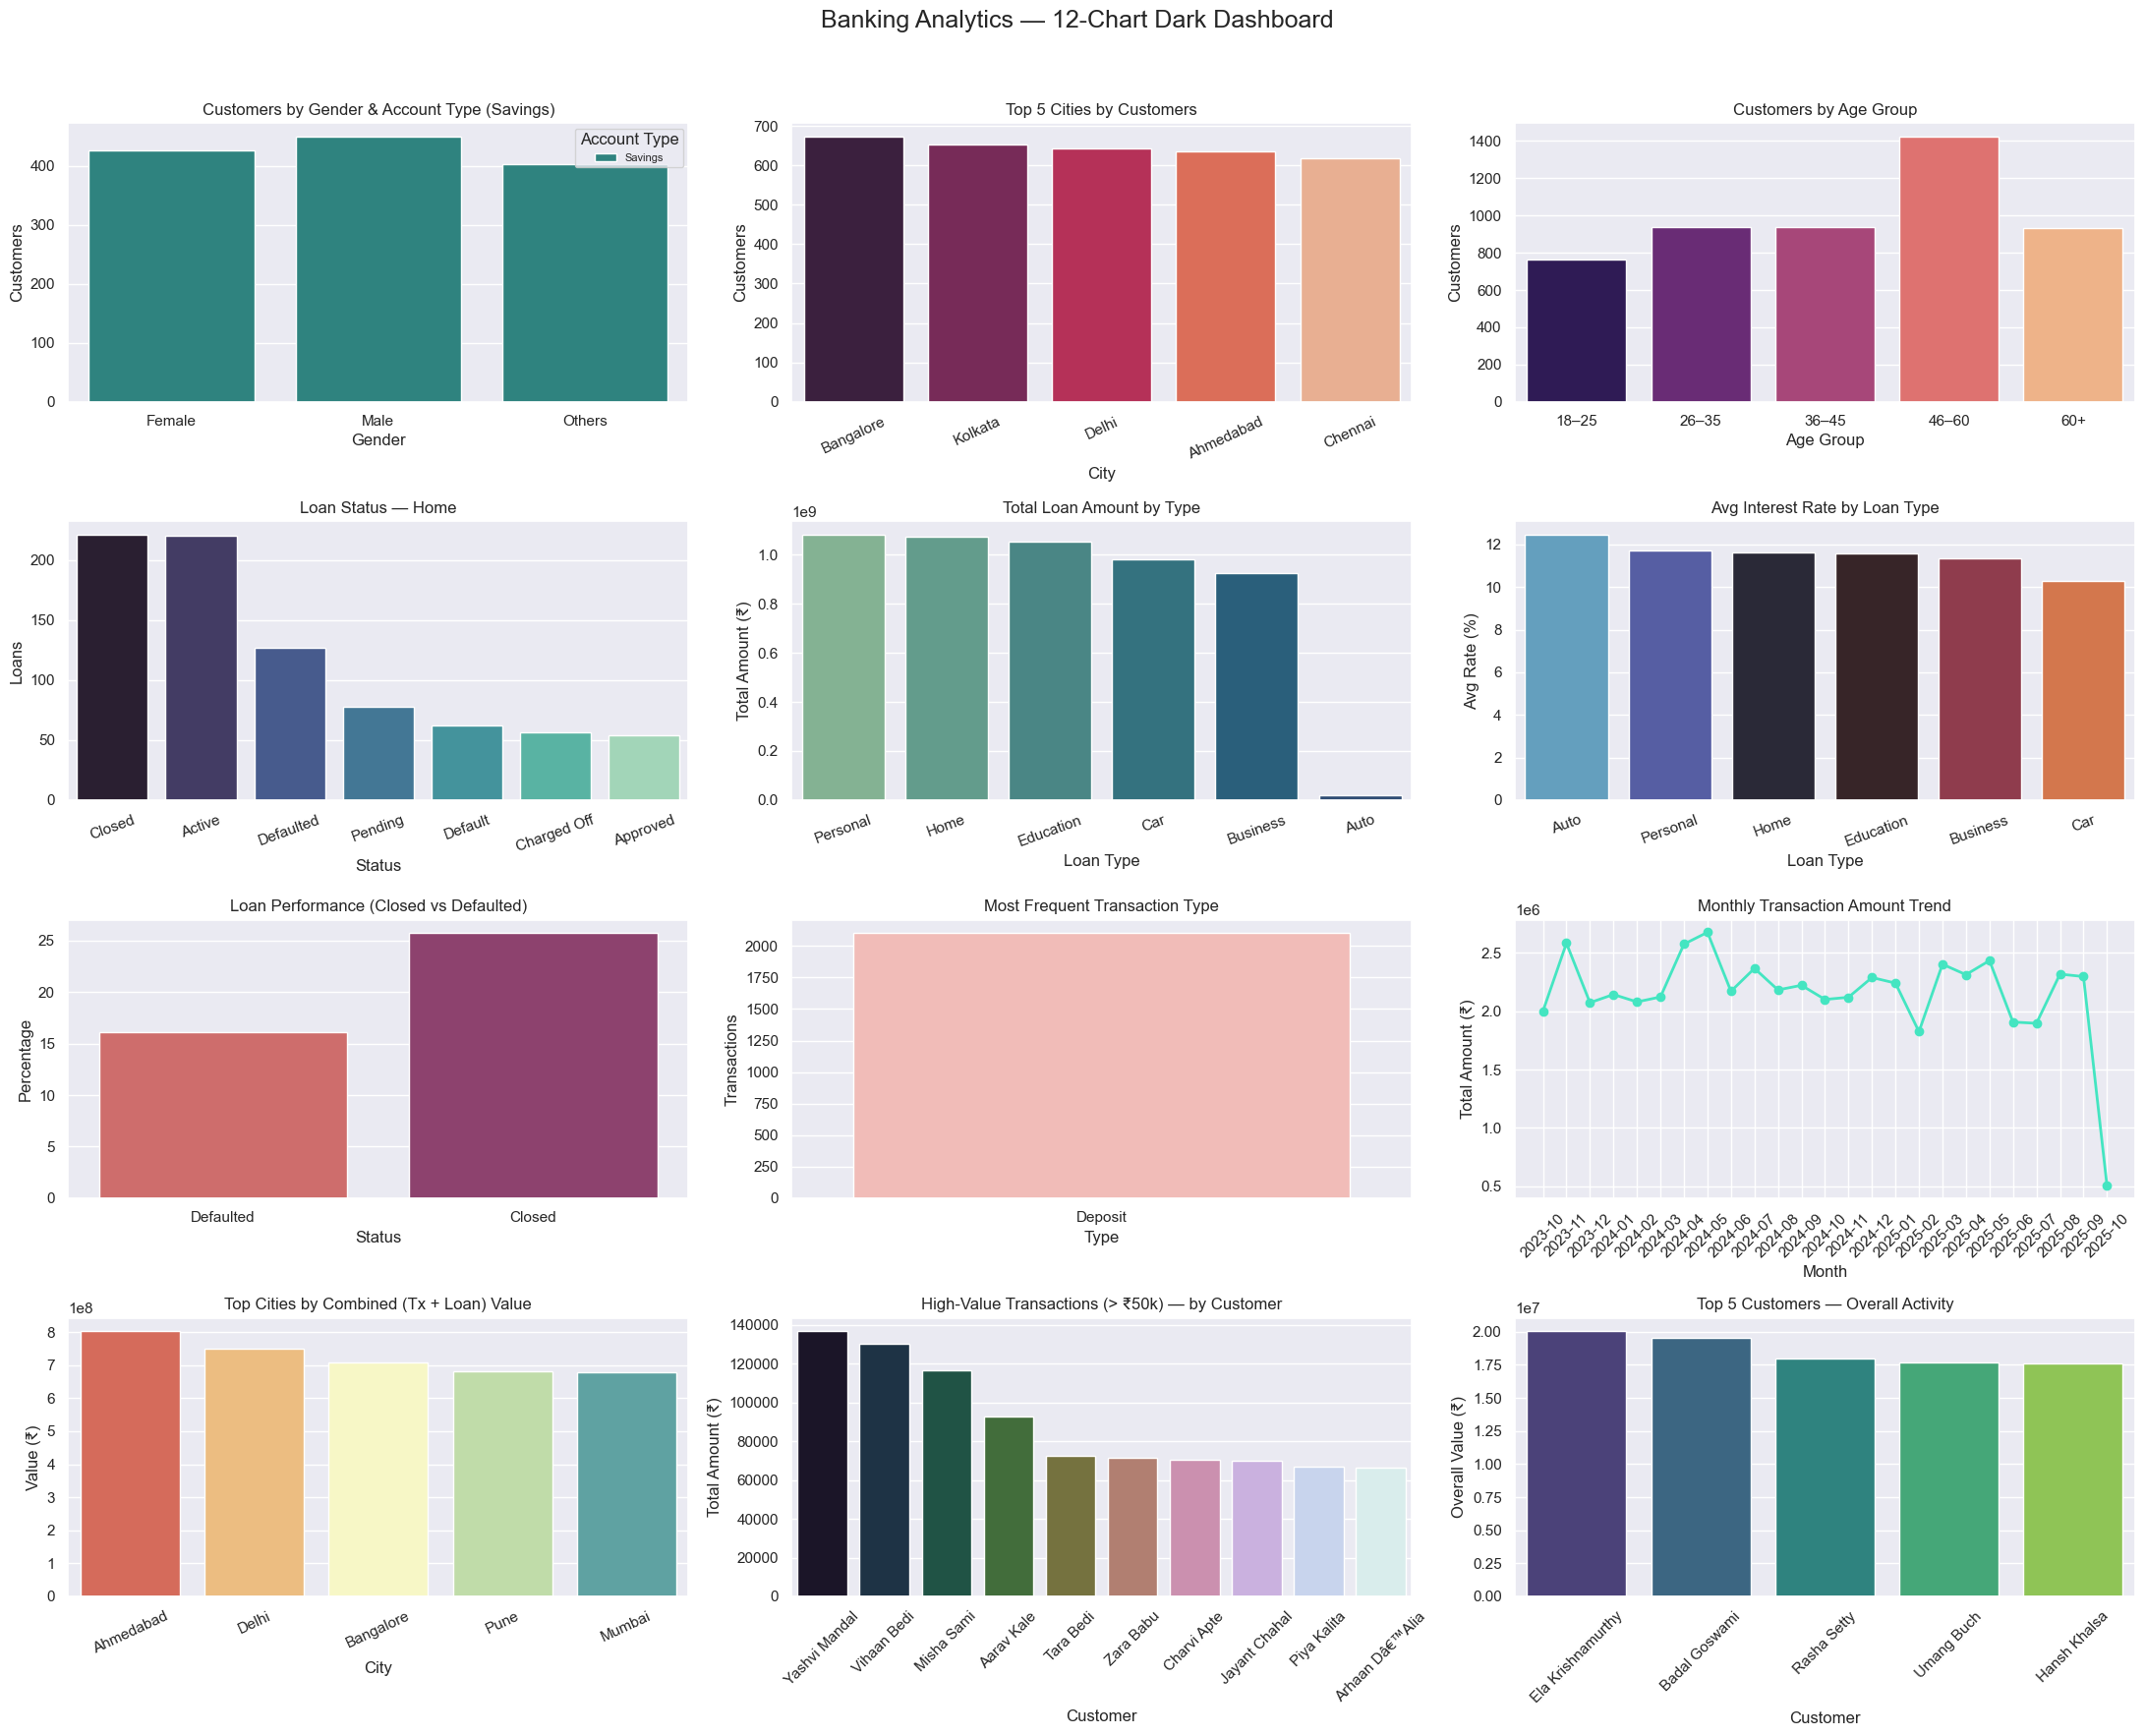

In [1]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mysql.connector import Error

# =========================
# DB CONFIG
# =========================
DB_CONFIG = {
    "host": "localhost",
    "user": "root",
    "password": "14032002kD@",
    "database": "Banking"
}

# =========================
# THEMING (Dark Mode T3)
# =========================
plt.style.use('dark_background')
sns.set_theme(style="darkgrid")
PALETTES = {
    "p1": "viridis",
    "p2": "rocket",
    "p3": "magma",
    "p4": "mako",
    "p5": "crest",
    "p6": "icefire",
    "p7": "flare",
    "p8": "Pastel1",
    "p9": "Spectral",
    "p10": "cubehelix"
}

# =========================
# DB HELPER
# =========================
def run_proc(proc_name, params=None):
    """
    Execute stored procedure and return (df, updated_params).
    NOTE: For OUT params, pass a LIST and read back updated values by index.
    """
    conn = None
    try:
        conn = mysql.connector.connect(**DB_CONFIG)
        cursor = conn.cursor()
        if params is not None:
            cursor.callproc(proc_name, params)  # list needed for OUT
        else:
            cursor.callproc(proc_name)

        df = None
        for result in cursor.stored_results():
            rows = result.fetchall()
            cols = [c[0] for c in result.description]
            df = pd.DataFrame(rows, columns=cols)
        return df, params
    except Error as e:
        print(f" Error running {proc_name}: {e}")
        return None, params
    finally:
        try:
            cursor.close()
        except:
            pass
        if conn and conn.is_connected():
            conn.close()

# =========================
# SAFE PLOT HELPERS
# =========================
def plot_no_data(ax, title):
    ax.set_title(title)
    ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=12, alpha=0.85)
    ax.axis("off")

def sort_desc(df, col):
    if df is None or df.empty or col not in df.columns:
        return df
    return df.sort_values(col, ascending=False)

# =========================
# USER INPUTS (at runtime)
# =========================
def get_user_inputs():
    print("\n  Dashboard Inputs")
    acc_type = input("• Account type filter for Q1 Like savings,current,fixed deposit,salary: ").title().strip()
    loan_type = input("• Loan type for status distribution (e.g., Home/Car/Auto/Education/Personal/Business): ").title().strip()
    try:
        top_n = input("• Top-N customers for overall activity (e.g., 10): ").strip()
        top_n = int(top_n) if top_n else 10
    except:
        top_n = 10

    print("\n• High-value transactions grouping:")
    print("  H1 = by Transaction Type, H2 = by City, H3 = by Customer, H4 = Type+City (two mini-bars)")
    hv_choice = input("  Enter H1/H2/H3/H4: ").strip().upper()
    if hv_choice not in {"H1","H2","H3","H4"}:
        hv_choice = "H1"

    # normalize blanks
    acc_type = acc_type if acc_type else None
    loan_type = loan_type if loan_type else "Home"
    return acc_type, loan_type, top_n, hv_choice

# =========================
# DASHBOARD (12 SUBPLOTS)
# =========================
def build_dashboard(acc_type_filter, loan_type_for_status, top_n_customers, hv_group_choice):
    fig, axes = plt.subplots(4, 3, figsize=(22, 18))
    fig.suptitle(" Banking Analytics — 12-Chart Dark Dashboard", fontsize=18, y=0.98)

    # ---------------- Q1: Customers by Gender & Account Type (IN acc_type, OUT total_count)
    ax = axes[0, 0]
    params = [acc_type_filter, 0]
    df, updated = run_proc("total_customers_by_gender_account", params)
    ttl = f"Customers by Gender & Account Type ({acc_type_filter or 'All'})"
    if df is None or df.empty or not set(["gender","account_type","total_customers"]).issubset(df.columns):
        plot_no_data(ax, ttl)
    else:
        sns.barplot(data=df, x="gender", y="total_customers", hue="account_type", ax=ax, palette=PALETTES["p1"])
        ax.set_title(ttl); ax.set_xlabel("Gender"); ax.set_ylabel("Customers")
        ax.legend(fontsize=8, title="Account Type")

    # ---------------- Q2: Top 5 Cities by Customers
    ax = axes[0, 1]
    df, _ = run_proc("top_5_locations")
    ttl = "Top 5 Cities by Customers"
    if df is None or df.empty or not set(["city","total_customers"]).issubset(df.columns):
        plot_no_data(ax, ttl)
    else:
        df_plot = sort_desc(df, "total_customers")
        sns.barplot(data=df_plot, x="city", y="total_customers", ax=ax, palette=PALETTES["p2"])
        ax.set_title(ttl); ax.set_xlabel("City"); ax.set_ylabel("Customers")
        for t in ax.get_xticklabels(): t.set_rotation(25)

    # ---------------- Q3: Customers by Age Group
    ax = axes[0, 2]
    df, _ = run_proc("customers_by_age_group")
    ttl = "Customers by Age Group"
    if df is None or df.empty or not set(["age_group","total_customers"]).issubset(df.columns):
        plot_no_data(ax, ttl)
    else:
        sns.barplot(data=df, x="age_group", y="total_customers", ax=ax, palette=PALETTES["p3"])
        ax.set_title(ttl); ax.set_xlabel("Age Group"); ax.set_ylabel("Customers")

    # ---------------- Q4: Loans — Status distribution for selected type (IN, OUT)
    ax = axes[1, 0]
    params = [loan_type_for_status, 0]
    df, updated = run_proc("count_loans_by_status", params)
    ttl = f"Loan Status — {loan_type_for_status}"
    if df is None or df.empty or not set(["loan_status","total_loans"]).issubset(df.columns):
        plot_no_data(ax, ttl)
    else:
        sns.barplot(data=df, x="loan_status", y="total_loans", ax=ax, palette=PALETTES["p4"])
        ax.set_title(ttl); ax.set_xlabel("Status"); ax.set_ylabel("Loans")
        for t in ax.get_xticklabels(): t.set_rotation(20)

    # ---------------- Q5: Loans — Total amount by type
    ax = axes[1, 1]
    df, _ = run_proc("total_loan_amount_by_type")
    ttl = "Total Loan Amount by Type"
    if df is None or df.empty or not set(["loan_type","total_disbursed_amount"]).issubset(df.columns):
        plot_no_data(ax, ttl)
    else:
        df_plot = sort_desc(df, "total_disbursed_amount")
        sns.barplot(data=df_plot, x="loan_type", y="total_disbursed_amount", ax=ax, palette=PALETTES["p5"])
        ax.set_title(ttl); ax.set_xlabel("Loan Type"); ax.set_ylabel("Total Amount (₹)")
        for t in ax.get_xticklabels(): t.set_rotation(20)

    # ---------------- Q6: Loans — Avg interest rate by type
    ax = axes[1, 2]
    df, _ = run_proc("avg_interest_rate_by_type")
    ttl = "Avg Interest Rate by Loan Type"
    if df is None or df.empty or not set(["loan_type","avg_interest_rate"]).issubset(df.columns):
        plot_no_data(ax, ttl)
    else:
        df_plot = sort_desc(df, "avg_interest_rate")
        sns.barplot(data=df_plot, x="loan_type", y="avg_interest_rate", ax=ax, palette=PALETTES["p6"])
        ax.set_title(ttl); ax.set_xlabel("Loan Type"); ax.set_ylabel("Avg Rate (%)")
        for t in ax.get_xticklabels(): t.set_rotation(20)

    # ---------------- Q7: Loans — Performance summary (Closed vs Defaulted)
    ax = axes[2, 0]
    df, _ = run_proc("loan_performance_summary")
    ttl = "Loan Performance (Closed vs Defaulted)"
    if df is None or df.empty or "status" not in df.columns:
        plot_no_data(ax, ttl)
    else:
        y = "percentage" if "percentage" in df.columns else ("total_loans" if "total_loans" in df.columns else None)
        if not y:
            plot_no_data(ax, ttl)
        else:
            sns.barplot(data=df, x="status", y=y, ax=ax, palette=PALETTES["p7"])
            ax.set_title(ttl); ax.set_xlabel("Status"); ax.set_ylabel(y.title())

    # ---------------- Q8: Transactions — Most frequent type
    ax = axes[2, 1]
    df, _ = run_proc("most_frequent_transaction_type")
    ttl = "Most Frequent Transaction Type"
    if df is None or df.empty or not set(["transaction_type","total_transactions"]).issubset(df.columns):
        plot_no_data(ax, ttl)
    else:
        sns.barplot(data=df, x="transaction_type", y="total_transactions", ax=ax, palette=PALETTES["p8"])
        ax.set_title(ttl); ax.set_xlabel("Type"); ax.set_ylabel("Transactions")

    # ---------------- Q9: Transactions — Monthly trend (amount)
    ax = axes[2, 2]
    df, _ = run_proc("monthly_transaction_trends")
    ttl = "Monthly Transaction Amount Trend"
    if df is None or df.empty or not set(["month","total_transaction_amount"]).issubset(df.columns):
        plot_no_data(ax, ttl)
    else:
        df_plot = df.sort_values("month")
        ax.plot(df_plot["month"], df_plot["total_transaction_amount"], marker="o", linewidth=2, color="#44e5c1")
        ax.set_title(ttl); ax.set_xlabel("Month"); ax.set_ylabel("Total Amount (₹)")
        for t in ax.get_xticklabels(): t.set_rotation(45)

    # ---------------- Q10: Combined — Top cities by combined activity
    ax = axes[3, 0]
    df, _ = run_proc("top_cities_by_financial_activity")
    ttl = "Top Cities by Combined (Tx + Loan) Value"
    if df is None or df.empty or "city" not in df.columns:
        plot_no_data(ax, ttl)
    else:
        ycol = "combined_total" if "combined_total" in df.columns else ("total_transaction_amount" if "total_transaction_amount" in df.columns else None)
        if not ycol:
            plot_no_data(ax, ttl)
        else:
            df_plot = sort_desc(df, ycol)
            sns.barplot(data=df_plot, x="city", y=ycol, ax=ax, palette=PALETTES["p9"])
            ax.set_title(ttl); ax.set_xlabel("City"); ax.set_ylabel("Value (₹)")
            for t in ax.get_xticklabels(): t.set_rotation(25)

    # ---------------- Q11: Transactions — High-value (>50k) grouped by user's choice
    ax = axes[3, 1]
    df, _ = run_proc("high_value_transactions")
    base_ttl = "High-Value Transactions (> ₹50k)"
    if df is None or df.empty:
        plot_no_data(ax, base_ttl)
    else:
        if hv_group_choice == "H1" and set(["transaction_type","amount"]).issubset(df.columns):
            ttl = f"{base_ttl} — by Type"
            agg = df.groupby("transaction_type", as_index=False)["amount"].sum().sort_values("amount", ascending=False)
            sns.barplot(data=agg, x="transaction_type", y="amount", ax=ax, palette=PALETTES["p10"])
            ax.set_title(ttl); ax.set_xlabel("Type"); ax.set_ylabel("Total Amount (₹)")

        elif hv_group_choice == "H2" and set(["city","amount"]).issubset(df.columns):
            ttl = f"{base_ttl} — by City"
            agg = df.groupby("city", as_index=False)["amount"].sum().sort_values("amount", ascending=False).head(10)
            sns.barplot(data=agg, x="city", y="amount", ax=ax, palette=PALETTES["p10"])
            ax.set_title(ttl); ax.set_xlabel("City"); ax.set_ylabel("Total Amount (₹)")
            for t in ax.get_xticklabels(): t.set_rotation(25)

        elif hv_group_choice == "H3" and set(["full_name","amount"]).issubset(df.columns):
            ttl = f"{base_ttl} — by Customer"
            agg = df.groupby("full_name", as_index=False)["amount"].sum().sort_values("amount", ascending=False).head(10)
            sns.barplot(data=agg, x="full_name", y="amount", ax=ax, palette=PALETTES["p10"])
            ax.set_title(ttl); ax.set_xlabel("Customer"); ax.set_ylabel("Total Amount (₹)")
            for t in ax.get_xticklabels(): t.set_rotation(45)

        elif hv_group_choice == "H4" and set(["transaction_type","city","amount"]).issubset(df.columns):
            ttl = f"{base_ttl} — Type & City"
            # compress to top types to keep subplot readable
            top_types = df["transaction_type"].value_counts().index[:3]
            dfx = df[df["transaction_type"].isin(top_types)].groupby(["transaction_type","city"], as_index=False)["amount"].sum()
            sns.barplot(data=dfx, x="city", y="amount", hue="transaction_type", ax=ax, palette=PALETTES["p10"])
            ax.set_title(ttl); ax.set_xlabel("City"); ax.set_ylabel("Total Amount (₹)")
            for t in ax.get_xticklabels(): t.set_rotation(25)
            ax.legend(fontsize=8, title="Type")
        else:
            plot_no_data(ax, base_ttl + " (Unsupported grouping columns)")

    # ---------------- Q12: Combined — Top N customers by overall activity (IN top_n)
    ax = axes[3, 2]
    df, _ = run_proc("topn_customers_activity", [top_n_customers])
    ttl = f"Top {top_n_customers} Customers — Overall Activity"
    # Expected cols: full_name, total_transaction_amount, total_loan_amount, overall_value
    if df is None or df.empty or not set(["full_name","overall_value"]).issubset(df.columns):
        plot_no_data(ax, ttl)
    else:
        df_plot = sort_desc(df, "overall_value").head(top_n_customers)
        sns.barplot(data=df_plot, x="full_name", y="overall_value", ax=ax, palette=PALETTES["p1"])
        ax.set_title(ttl); ax.set_xlabel("Customer"); ax.set_ylabel("Overall Value (₹)")
        for t in ax.get_xticklabels(): t.set_rotation(45)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# =========================
# RUN
# =========================
if __name__ == "__main__":
    acc_type, loan_type, top_n, hv_choice = get_user_inputs()
    build_dashboard(acc_type, loan_type, top_n, hv_choice)
